## 딥러닝

딥러닝은 머신러닝의 한 학습 방법으로 신경망 모델이라 불림.
층을 많이 활용한 모델
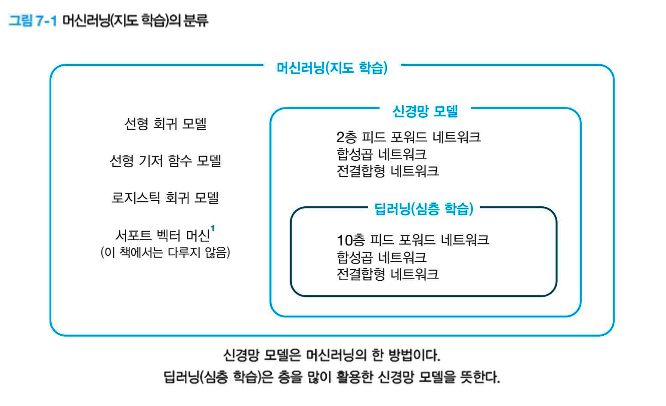


## 뉴런모델

: 뇌의 신경세포에서 힌트를 얻어 만들어진 수학적 모델

신경망 모델은 뉴런모델 단위로 구축된다.

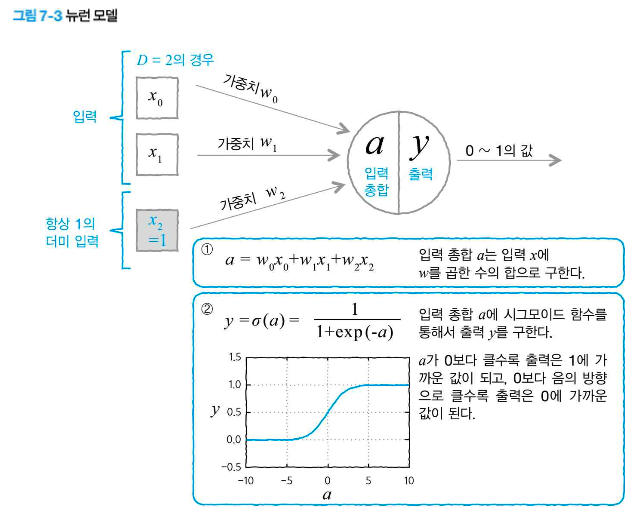

input은 양수와 음수를 갖는 실수값,

각각 입력에 대한 가중치를 w0, w1

이들의 곱으로 얻은 상수 w2(Bias)를 더한 것을 입력 총합 a로 한다.

## 신경망 모델

### 2층 피드 포워드 신경망
신호가 되돌아가지고 않고 한 방향으로만 흐르는 신경망

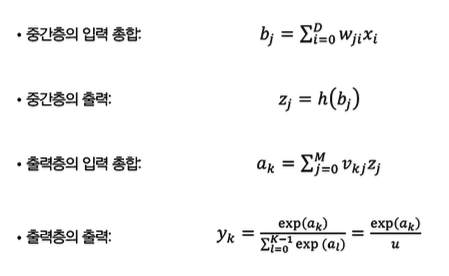

In [1]:
import numpy as np

np.random.seed(seed=1)
N = 200 # 데이터의 수
K = 3 # 분포의 수
T = np.zeros((N, 3), dtype=np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3] # x0의 범위, 표시용
X_range1 = [-3, 3] # x1의 범위
Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 분포의 중심
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]]) # 분포의 분산
Pi = np.array([0.4, 0.8, 1]) # 각 분포에 대한 비율
for n in range(N):
  wk = np.random.rand()
  for k in range(K):
    if wk < Pi[k]:
      T[n, k] = 1
      break
  for k in range(2):
    X[n, k] = np.random.randn() * Sig[T[n, :] == 1, k] + Mu[T[n, :] == 1, k]


In [2]:
TestRatio = 0.5
X_n_training = int(N * TestRatio)
X_train = X[:X_n_training, :]
X_test = X[X_n_training:, :]
T_train = T[:X_n_training, :]
T_test = T[X_n_training:, :]

np.savez('class_data.npz', X_train = X_train, T_train = T_train, X_test = X_test, T_test = T_test, X_range0 = X_range0, X_range1 = X_range1)

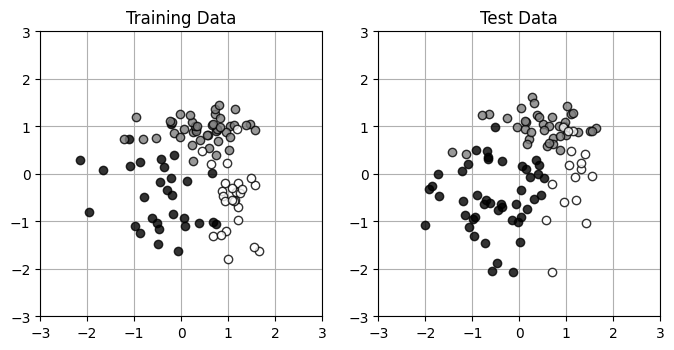

In [3]:
# 분할한 데이터 그리기
import matplotlib.pyplot as plt
%matplotlib inline

# 분포 표시용 함수
def Show_data(x, t):
  wk, n = t.shape
  c = [[0, 0, 0],[.5, .5, .5], [1, 1, 1]]
  for i in range(n):
    plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1],
             linestyle='none',
             marker='o', markeredgecolor='black',
             color=c[i], alpha=0.8)
    plt.grid(True)

plt.figure(1, figsize=(8, 3.7))
plt.subplot(1, 2, 1)
Show_data(X_train, T_train)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Training Data')
plt.subplot(1, 2, 2)
Show_data(X_test, T_test)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Test Data')
plt.show()

In [4]:
def Sigmoid(x):
  y = 1/(1 + np.exp(-x))
  return y

def FNN(wv, M, K, x):
  N, D = x.shape
  w = wv[:M * (D + 1)]
  w = w.reshape(M, (D + 1))# 중간층의 매개 변수
  v = wv[M * (D + 1):]
  v = v.reshape((K, M + 1))# 출력층의 매개 변수
  b = np.zeros((N, M + 1))# 중간층 입력 총합
  z = np.zeros((N, M + 1))# 중간층의 출력
  a = np.zeros((N, K))# 출력층의 입력 총합
  y = np.zeros((N, K))# 출력층의 출력
  for n in range(N):
    for m in range(M):
      b[n, m] = np.dot(w[m, :], np.r_[x[n, :], 1])
      z[n, m] = Sigmoid(b[n, m])
    z[n, M] = 1
    wkz = 0
    for k in range(K):
      a[n, k] = np.dot(v[k, :], z[n, :])
      wkz = wkz + np.exp(a[n, k])
    for k in range(K):
      y[n, k] = np.exp(a[n, k]) / wkz
  return y, a, z, b

# 행 동작 체크
WV = np.ones(15)
M = 2
K = 3 # wv는 길이가 2*3 + 3*3 = 15인 가중치 벡터
FNN(WV, M, K, X_train[:2, :])

(array([[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333]]),
 array([[2.6971835 , 2.6971835 , 2.6971835 ],
        [1.49172649, 1.49172649, 1.49172649]]),
 array([[0.84859175, 0.84859175, 1.        ],
        [0.24586324, 0.24586324, 1.        ]]),
 array([[ 1.72359839,  1.72359839,  0.        ],
        [-1.12079826, -1.12079826,  0.        ]]))

### 수치미분

평균 엔트로피 오차를 사용

성실하게 미분을 계산하지 않아도 근사적으로 기울기를 계산하자

단점: 정밀도의 오차보다는 계산 비용! 한 매개변수의 미분을 계산하기 위한 매개변수 하나에 두 번의 E의 계산이 필요



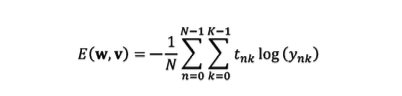


In [5]:
# 평균 교차 엔트로피 오차
def CE_FNN(wv, M, K, x, t):
  N, D = x.shape
  y, a, z, b = FNN(wv, M, K, x)
  ce = -np.dot(np.log(y.reshape(-1)), t.reshape(-1)) / N
  return ce

# 동작 체크
WV = np.ones(15)
M = 2
K = 3
CE_FNN(WV, M, K, X_train[:2, :], T_train[:2, :])

1.0986122886681098

[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


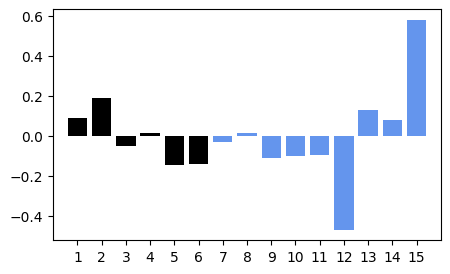

In [6]:
def dCE_FNN_num(wv, M, K, x, t):
  epsilon = 0.001 # 입실론 정의
  dwv = np.zeros_like(wv)
  for iwv in range(len(wv)):
    wv_modified = wv.copy()
    wv_modified[iwv] = wv[iwv] - epsilon
    mse1 = CE_FNN(wv_modified, M, K, x, t)
    wv_modified[iwv] = wv[iwv] + epsilon
    mse2 = CE_FNN(wv_modified, M, K, x, t)
    dwv[iwv] = (mse2 - mse1) / (2 * epsilon)
  return dwv

def Show_WV(wv, M):
  N = wv.shape[0]
  plt.bar(range(1, M * 3 + 1), wv[:M * 3], align="center", color="black")
  plt.bar(range(M * 3 + 1, N + 1), wv[M * 3:],
          align="center", color="cornflowerblue")
  plt.xticks(range(1, N + 1))
  plt.xlim(0, N + 1)

M = 2
K = 3
nWV = M * 3 + K * (M + 1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)
dWV = dCE_FNN_num(WV, M, K, X_train[:2, :], T_train[:2, :])
print(dWV)
plt.figure(1, figsize=(5, 3))
Show_WV(dWV, M)
plt.show()

### 수치 미분법에 의한 경사하강법

지금까지와는 조금 다르게 입력에 학습시키는 가중치의 초기값으로 wv_init을 넣는다.

또 train뿐만 아니라 test data도 입력함.


In [7]:
import time

# 분류 문제를 경사 하강법으로 풀기
def Fit_FNN_num(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
  wvt = wv_init # 가중치의 초기값
  err_train = np.zeros(n)
  err_test = np.zeros(n)
  wv_hist = np.zeros((n, len(wv_init)))
  epsilon = 0.001
  for i in range(n): # 학습 단계 수
    wvt = wvt - alpha * dCE_FNN_num(wvt, M, K, x_train, t_train) # 매번 훈련데이터 오차와 테스트 데이터 오차 계산
    err_train[i] = CE_FNN(wvt, M, K, x_train, t_train)
    err_test[i] = CE_FNN(wvt, M, K, x_test, t_test) # 학습 단계별로 오버피팅 확인
    wv_hist[i, :] = wvt
  return wvt, wv_hist, err_train, err_test

startTime = time.time()
M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))
N_step = 1000
alpha = 0.5 # 학습 상수
WV, WV_hist, Err_train, Err_test = Fit_FNN_num(
    WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

Calculation time:172.960 sec


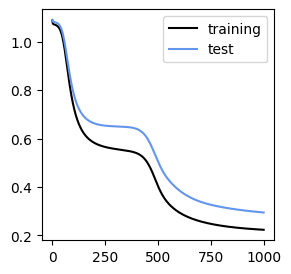

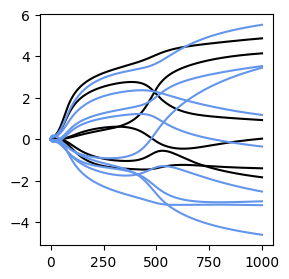

In [8]:
#학습 오차의 표시

plt.figure(1, figsize=(3, 3))
plt.plot(Err_train, 'black', label='training')
plt.plot(Err_test, 'cornflowerblue', label='test')
plt.legend()
plt.show()

#가중치의 시간 변화의 표시

plt.figure(1, figsize=(3, 3))
plt.plot(WV_hist[:, :M*3], 'black')
plt.plot(WV_hist[:, M * 3:], 'cornflowerblue')
plt.show()

중간층의 가중치 W를 검정, 출력층의 가중치 v를 파랑

-> 0 주변의 기본 값으로 시작된 가중치는 각각 특정값으로 수렴하고 있다.

아래 그래프를 보면 400단계 부근에서 각각 가중치 그래프가 교차하고 있다

이는 가중치를 갱신하는 방향, 즉 오차함수 기울기의 방향이 변화하는 것을 의미

--> 가중치가 안장점 근처를 통과했기 때문!

### 안장점

어느 방향에서 보면 극대값, 다른 방향에선 극솟값인 지점

* 경사하강법에서는 학습의 진행은 안장점에서 느려지고, 그곳을 넘으면 학습의 방향이 바뀐다.

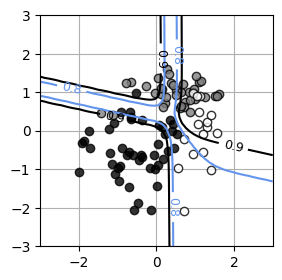

In [9]:
# 경계선 표시 함수
def show_FNN(wv, M, K):
  xn = 60
  x0 = np.linspace(X_range0[0], X_range0[1], xn)
  x1 = np.linspace(X_range1[0], X_range1[1], xn)
  xx0, xx1 = np.meshgrid(x0, x1)
  x = np.c_[np.reshape(xx0, (xn * xn, 1)), np.reshape(xx1, (xn * xn, 1))]
  y, a, z, b = FNN(wv, M, K, x)
  plt.figure(1, figsize=(4, 4))
  for ic in range(K):
    f = y[:, ic]
    f = f.reshape(xn, xn)
    f = f.T
    cont = plt.contour(xx0, xx1, f, levels=[0.8, 0.9],
                       colors=['cornflowerblue', 'black'])
    cont.clabel(fmt='%1.1f', fontsize=9)
    plt.xlim(X_range0)
    plt.ylim(X_range1)

plt.figure(1, figsize=(3, 3))
Show_data(X_test, T_test)
show_FNN(WV, M, K)
plt.show()


수치미분은 실행 속도가 느리다 -> 개선하자! 오차 역전파!

### 오차 역전파법

네트워크의 출력에서 발생하는 오차의 정보를 사용하여 출력층의 가중치에서 중간층의 가중치로 입력방향의 반대로 가중치를 갱신해 나간다.

사실 오차 역전파 법은 경사하강법!




analytical dWV
[ 0.08848131  0.19158    -0.051398    0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115649 -0.10104422 -0.09427964 -0.46855604
  0.13096434  0.08076649  0.57971253]
numerical dWV
[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


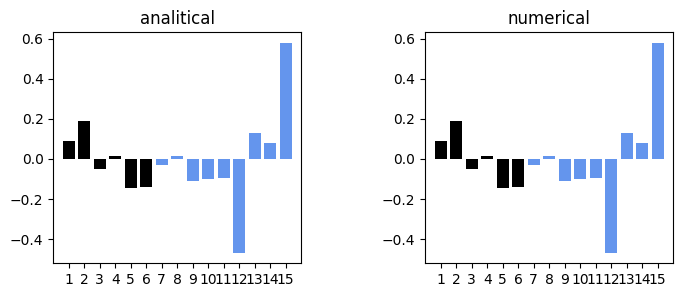

In [10]:
# 해석적 미분
def dCE_FNN(wv, M, K, x, t):
  N, D = x.shape
  # wv을 w와 v로 되돌림
  w = wv[:M * (D + 1)]
  w = w.reshape(M, (D + 1))
  v = wv[M * (D + 1):]
  v = v.reshape((K, M + 1))
  # x를 입력하여 y를 얻음
  y, a, z, b = FNN(wv, M, K, x)
  # 출력 변수의 준비
  dwv = np.zeros_like(wv)
  dw = np.zeros((M, D + 1))
  dv = np.zeros((K, M + 1))
  delta1 = np.zeros(M) # 1층 오차
  delta2 = np.zeros(K) # 2층 오차 (k = 0인 부분은 사용 안 함)
  for n in range(N):
    # 출력층의 오차 구하기
    for k in range(K):
      delta2[k] = (y[n, k] - t[n, k])
    # 중간층의 오차 구하기
    for j in range(M):
      delta1[j] = z[n, j] * (1 - z[n, j]) * np.dot(v[:, j], delta2)
    # v의 기울기 dv를 구하기
    for k in range(K):
      dv[k, :] = dv[k, :] + delta2[k] * z[n, :] / N
    # w의 기울기 dw를 구하기
    for j in range(M):
      dw[j, :] = dw[j, :] + delta1[j] * np.r_[x[n, :], 1] / N
  # dw와 dv를 합체시킨 dwv로 만들기
  dwv = np.c_[dw.reshape((1, M * (D + 1))),
              dv.reshape((1, K * (M + 1)))]
  dwv = dwv.reshape(-1)
  return dwv

def Show_dWV(wv, M):
  N = wv.shape[0]
  plt.bar(range(1, M * 3 + 1), wv[:M * 3],
          align = "center", color = "black")
  plt.bar(range(M * 3 + 1, N + 1), wv[M * 3:],
          align="center", color='cornflowerblue')
  plt.xticks(range(1, N + 1))
  plt.xlim(0, N + 1)

# 동작 확인
M = 2
K = 3
N = 2
nWV = M * 3 + K * (M + 1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)


dWV_ana = dCE_FNN(WV, M, K, X_train[:N, :], T_train[:N, :])
print("analytical dWV")
print(dWV_ana)

dWV_num = dCE_FNN_num(WV, M, K, X_train[:N, :], T_train[:N, :])
print("numerical dWV")
print(dWV_num)

plt.figure(1, figsize=(8, 3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 1)
Show_dWV(dWV_ana, M)
plt.title('analitical')
plt.subplot(1, 2, 2)
Show_dWV(dWV_num, M)
plt.title('numerical')
plt.show()

In [11]:
import time


# 해석적 미분을 사용한 구배법 -------
def Fit_FNN(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
    wv = wv_init.copy()
    err_train = np.zeros(n)
    err_test = np.zeros(n)
    wv_hist = np.zeros((n, len(wv_init)))
    epsilon = 0.001
    for i in range(n):
        wv = wv - alpha * dCE_FNN(wv, M, K, x_train, t_train) # (A)
        err_train[i] = CE_FNN(wv, M, K, x_train, t_train)
        err_test[i] = CE_FNN(wv, M, K, x_test, t_test)
        wv_hist[i, :] = wv
    return wv, wv_hist, err_train, err_test


# 메인 ---------------------------
startTime = time.time()
M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))
N_step = 1000
alpha = 1
WV, WV_hist, Err_train, Err_test = Fit_FNN(
    WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

Calculation time:19.947 sec


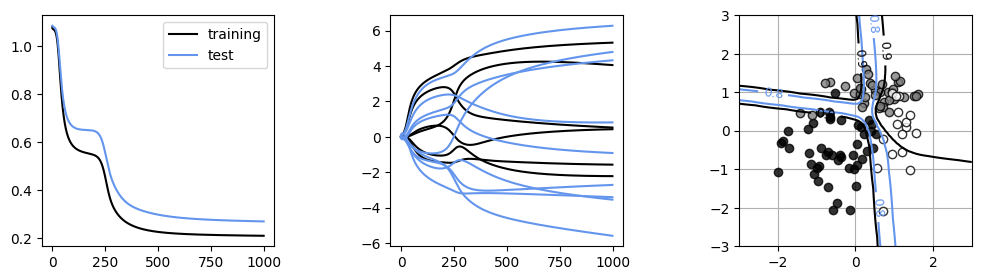

In [12]:
plt.figure(1, figsize=(12, 3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 3, 1)
plt.plot(Err_train, 'black', label='training')
plt.plot(Err_test, 'cornflowerblue', label='test')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(WV_hist[:, :M * 3], 'black')
plt.plot(WV_hist[:, M * 3:], 'cornflowerblue')
plt.subplot(1, 3, 3)
Show_data(X_test, T_test)
M = 2
K = 3
show_FNN(WV, M, K)
plt.show()


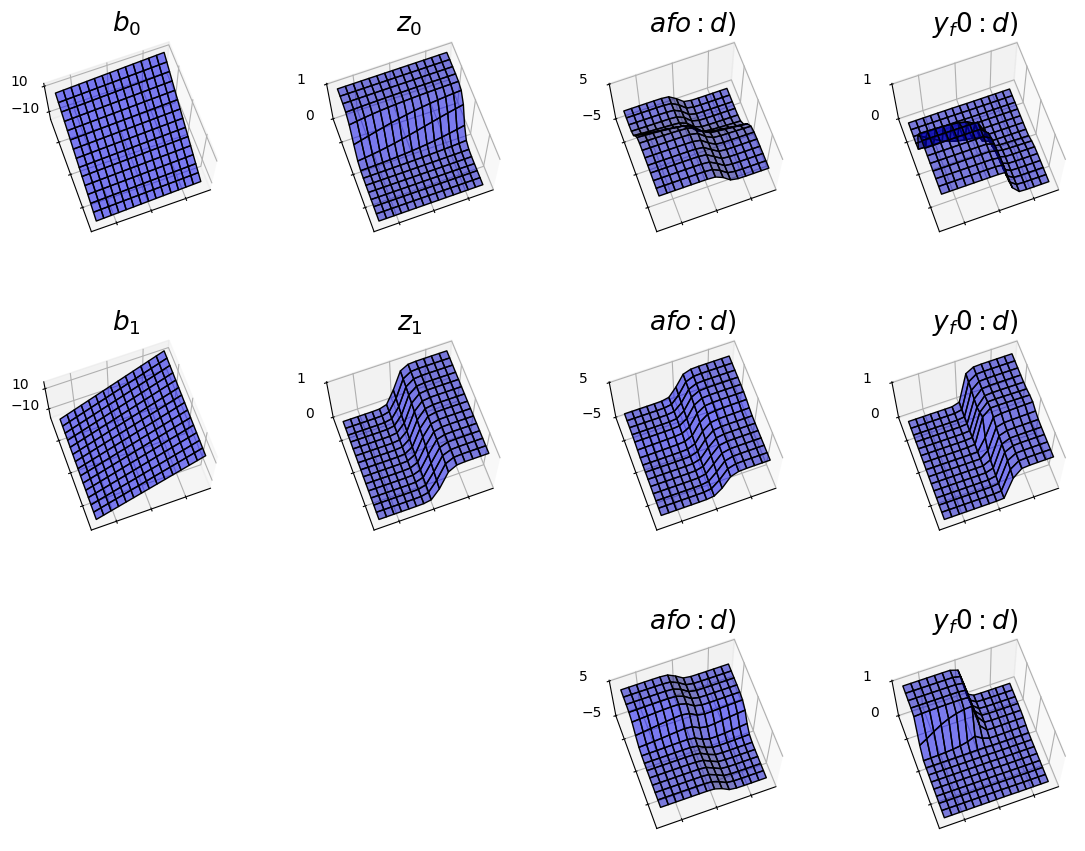

In [15]:
def show_activation3d(ax, v, v_ticks, title_str):
  f = v.copy()
  f = f.reshape(xn, xn)
  f = f.T
  ax.plot_surface(xx0, xx1, f, color="blue", edgecolor="black",
                  rstride=1, cstride=1, alpha=0.5)
  ax.view_init(70, -110)
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.set_zticks(v_ticks)
  ax.set_title(title_str, fontsize=19)

M = 2
K = 3
xn = 15
x0 = np.linspace(X_range0[0], X_range0[1], xn)
x1 = np.linspace(X_range1[0], X_range1[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
x = np.c_[np.reshape(xx0, (xn * xn, 1)), np.reshape(xx1, (xn * xn, 1))]
y, a, z, b = FNN(WV, M, K, x)

fig = plt.figure(1, figsize=(12, 9))
plt.subplots_adjust(left=0.075, bottom=0.05, right=0.95,
                    top=0.95, wspace=0.4, hspace=0.4)

for m in range(M):
  ax = fig.add_subplot(3, 4, 1 + m * 4, projection='3d')
  show_activation3d(ax, b[:, m], [-10, 10], '$b_{0:d}$'.format(m))
  ax = fig.add_subplot(3, 4, 2 + m * 4, projection='3d')
  show_activation3d(ax, z[:, m], [0, 1], '$z_{0:d}$'.format(m))

for k in range(K):
  ax = fig.add_subplot(3, 4, 3 + k * 4, projection="3d")
  show_activation3d(ax, a[:, k], [-5, 5], '$a fo:d)$'.format(k))
  ax = fig.add_subplot(3, 4, 4 + k * 4, projection='3d')
  show_activation3d(ax, y[:, k], [0, 1], '$y_f0:d)$'.format(k))

plt.show()

In [16]:

%reset


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import time
np.random.seed(1)
import keras.optimizers
from keras.models import Sequential
from keras.layers import Dense, Activation

outfile = np.load('class_data.npz')
X_train = outfile['X_train']
T_train = outfile['T_train']
X_test = outfile['X_test']
T_test = outfile['T_test']
X_range0 = outfile['X_range0']
X_range1 = outfile['X_range1']

In [19]:

def Show_data(x, t):
  wk, n = t.shape
  c = [[0, 0, 0], [.5, .5, .5], [1, 1, 1]]
  for i in range(n):
    plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1],
             linestyle='none', marker='o',
             markeredgecolor='black',
             color=c[i], alhpa=0.8)
  plt.grid(True)

In [20]:
np.random.seed(1)

# Sequential 모델 작성(객체, 여러변수와 함수를 묶은 것)
model = Sequential()
# 중간 층, 2는 뉴런의 수, 입력 차원도 2차원, bias는 기본, 가중치 매개 변수는 균일 난수
model.add(Dense(2, input_dim=2, activation='sigmoid',
                kernel_initializer='uniform'))
# 출력 층도 정의
model.add(Dense(3, activation='softmax',
                kernel_initializer='uniform'))
# 학습 방법의 설정
sgd = keras.optimizers.SGD(learning_rate = 1, momentum=0.0,
                           nesterov=False)
# 학습 설정 전달, loss로 교차 엔트로피 오차, 평가로는 정답률
model.compile(optimizer=sgd, loss='categorical_crossentropy',
              metrics=['accuracy'])

# 학습
startTime = time.time()
# 실제 학습, batch_size는 1단계 분의 기울기를 계산하는데 사용하는 학습 데이터의 수, epochs는 전체 데이터를 학습에 사용한 횟수
history = model.fit(X_train, T_train, epochs=1000, batch_size=100,
                    verbose=0, validation_data=(X_test, T_test))

# 모델 평가, 최종 학습 평가 값 출력
score = model.evaluate(X_test, T_test, verbose=0)
print('cross entropy {0:3.2f}, accuracy {1:3.2f}'.format(score[0], score[1])) # 테스트 데이터의 상호 엔트로피 오차, 정답
calculation_time = time.time() - startTime
print("Calculation time:{0:.3f} sec".format(calculation_time))

cross entropy 0.26, accuracy 0.90
Calculation time:41.915 sec
